<a href="https://colab.research.google.com/github/Mohamed-Abgalow/Detecting-Pneumonia-using-Deep-learning/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import Callback, EarlyStopping
from keras.utils import to_categorical, load_img, img_to_array
from sklearn.metrics import confusion_matrix
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras import layers

In [ ]:
os.listdir("/content/drive/MyDrive/Deep learning pnuemonia /deep_learning_project/deep_learning_project/dataset1")

['known_images', 'unknown_images', 'readme.txt']

In [ ]:
def load_images():
    images_dir = Path('/content/drive/MyDrive/Deep learning pnuemonia /deep_learning_project/deep_learning_project/dataset1/known_images')
    normal_images = images_dir.glob('normal*.png')
    sick_images = images_dir.glob('sick*.png')
    img_data = []
    label_data = []
    for img in normal_images:
        img_data.append(img)
        label_data.append('normal')
    for img in sick_images:
        img_data.append(img)
        label_data.append('sick')
    df = pd.DataFrame(img_data)
    df.columns = ['images']
    df['labels'] = label_data
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [ ]:
df_known_images = load_images()

df_known_images

,images,labels
0,/content/drive/MyDrive/Deep learning pnuemonia...,normal
1,/content/drive/MyDrive/Deep learning pnuemonia...,sick
2,/content/drive/MyDrive/Deep learning pnuemonia...,sick
3,/content/drive/MyDrive/Deep learning pnuemonia...,normal
4,/content/drive/MyDrive/Deep learning pnuemonia...,sick
...,...,...
710,/content/drive/MyDrive/Deep learning pnuemonia...,sick
711,/content/drive/MyDrive/Deep learning pnuemonia...,normal
712,/content/drive/MyDrive/Deep learning pnuemonia...,sick
713,/content/drive/MyDrive/Deep learning pnuemonia...,normal


In [ ]:
df_known_images.shape

(715, 2)

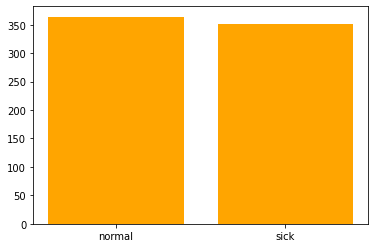

In [ ]:
plt.bar(df_known_images['labels'].value_counts().index, df_known_images['labels'].value_counts().values, color = "orange")
plt.show()

Visualising some of the many images

In [ ]:
def visualise_images(images, labels):
    plt.figure(figsize=(10,5))
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        img = cv2.imread(str(images[i]))
        img = cv2.resize(img, (150, 150))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis('off')

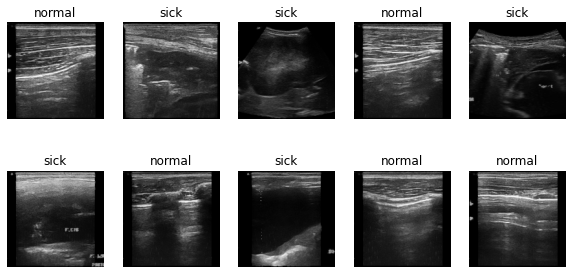

In [ ]:
visualise_images(df_known_images['images'], df_known_images['labels'])

Here We Will split data into training and testing

In [ ]:
def get_dataset_partitions_pd(df, train_split=0.8):
    train=df.sample(frac=train_split,random_state=150) #random state is a seed value

    test_validation=df.drop(train.index)

    test=test_validation.sample(frac=0.5,random_state=150) 

    validation = test_validation.drop(test.index)

    assert len(df) == len(train) + len(test) + len(validation) 

    return train, validation, test

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_pd(df_known_images)

In [ ]:
train_ds

,images,labels
234,/content/drive/MyDrive/Deep learning pnuemonia...,normal
179,/content/drive/MyDrive/Deep learning pnuemonia...,normal
256,/content/drive/MyDrive/Deep learning pnuemonia...,sick
125,/content/drive/MyDrive/Deep learning pnuemonia...,sick
645,/content/drive/MyDrive/Deep learning pnuemonia...,normal
...,...,...
515,/content/drive/MyDrive/Deep learning pnuemonia...,normal
19,/content/drive/MyDrive/Deep learning pnuemonia...,normal
140,/content/drive/MyDrive/Deep learning pnuemonia...,sick
284,/content/drive/MyDrive/Deep learning pnuemonia...,sick


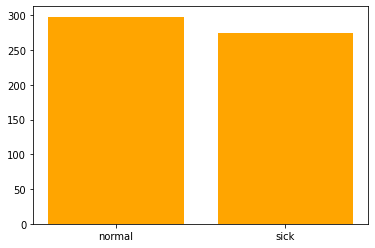

In [ ]:
plt.bar(train_ds['labels'].value_counts().index, train_ds['labels'].value_counts().values, color = "orange")
plt.show()

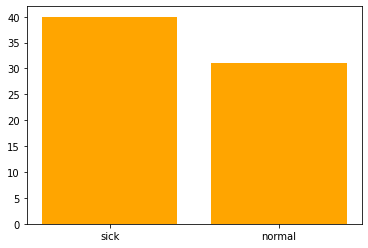

In [ ]:
plt.bar(val_ds['labels'].value_counts().index, val_ds['labels'].value_counts().values, color = "orange")
plt.show()

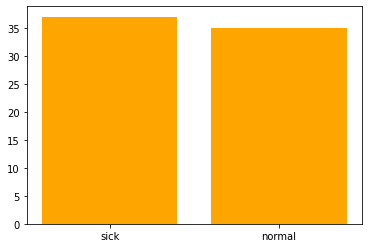

In [ ]:
plt.bar(test_ds['labels'].value_counts().index, test_ds['labels'].value_counts().values, color = "orange")
plt.show()

In [ ]:
Validation Datasets

In [ ]:
def prepare_dataset(images):

    normal_cases = images.loc[images['labels'] == 'normal']
    sick_cases = images.loc[images['labels'] == 'sick']
    data, labels = ([] for x in range(2))
    def prepare(case):
        for img in case['images']:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(150,150))
            #img = cv2.resize(img,(800,800))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if 'normal' in case['labels'].values:
                #print(case['labels'])
                label = to_categorical(0 , num_classes=2)
            else:
                #print(case['labels'])
                label = to_categorical(1 , num_classes=2)
            data.append(img)
            labels.append(label)
        return data, labels
    prepare(normal_cases)
    d,l = prepare(sick_cases)
    #print(l)
    d = np.array(d)
    l = np.array(l)
    return d,l

In [ ]:
val_data, val_labels = prepare_dataset(val_ds)
print(val_data)

[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0.01568628 0.01568628 0.01568628]
   [0.00784314 0.00784314 0.00784314]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.01960784 0.01960784 0.01960784]
   [0.07843138 0.07843138 0.07843138]
   [0.03921569 0.03921569 0.03921569]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  ...

  [[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   ...
   [0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.         0.         0.        ]
   [0. 

writing a function to generate images in batches from the train set

In [ ]:
def data_gen(data, batch_size):
    # Get total number of samples in the data
    n = len(data)
    steps = n//batch_size

    # define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, 150, 150, 3), dtype=np.float32) 
    batch_labels = np.zeros((batch_size, 2), dtype=np.float32)

    # get a numpy array of all the indices of the input data
    indices = np.arange(n) 

    # initialize a counter
    i = 0
    while True:
        
        #np.random.shuffle(indices)

        # Get the next batch
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['images']
            label = data.iloc[idx]['labels']
            if label=='normal':
                label=0
            else:
                label=1
            #one hot encoding
            encoded_label = to_categorical(label, num_classes=2)

            # read the image and resize
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (150, 150))

            # check if it's grayscale
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default

            #orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # normalize the image pixels
            orig_img = img.astype(np.float32)/255.

            batch_data[count] = orig_img
            batch_labels[count] = encoded_label

            count+=1

            if count==batch_size-1:
                break
        
        i+=1
        yield batch_data, batch_labels

        if i>=steps:
            i=0

In [ ]:
# Testing the data generation function
x = data_gen(train_ds, 160)

x

<generator object data_gen at 0x7f17f9b64c50>

Deep Learning CNN Model for prediction

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = (150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

In [ ]:
batch_size = 5
nb_epochs = 10

# Fetch the training data from the generator
train_data_gen = data_gen(data=train_ds, batch_size=batch_size)

# define number of training steps
nb_train_steps =  train_ds.shape[0]//batch_size

print(train_ds.shape)

print(train_data_gen)

print("Number of training and validation steps: {} and {} ".format(nb_train_steps, len(val_ds)))

(572, 2)
<generator object data_gen at 0x7f17f9b3ddd0>
Number of training and validation steps: 114 and 71 


We’ll use binary cross-entropy as our loss function because we have only 2 classes. Rmsprop will be our optimizer function. Training starts here.

In [ ]:
model.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

# Fit the model
history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data,val_labels))

Epoch 1/10
114/114 [==============================] - 125s 1s/step - loss: 0.3504 - accuracy: 0.6772 - val_loss: 0.2225 - val_accuracy: 0.8873
Epoch 2/10
114/114 [==============================] - 24s 211ms/step - loss: 0.1966 - accuracy: 0.9193 - val_loss: 0.1726 - val_accuracy: 0.9014
Epoch 3/10
114/114 [==============================] - 25s 219ms/step - loss: 0.1472 - accuracy: 0.9491 - val_loss: 0.1175 - val_accuracy: 0.9577
Epoch 4/10
114/114 [==============================] - 23s 202ms/step - loss: 0.0762 - accuracy: 0.9754 - val_loss: 0.1203 - val_accuracy: 0.9718
Epoch 5/10
114/114 [==============================] - 23s 206ms/step - loss: 0.0743 - accuracy: 0.9807 - val_loss: 0.1300 - val_accuracy: 0.9577
Epoch 6/10
114/114 [==============================] - 23s 201ms/step - loss: 0.0285 - accuracy: 0.9930 - val_loss: 0.1904 - val_accuracy: 0.9718
Epoch 7/10
114/114 [==============================] - 22s 196ms/step - loss: 0.0355 - accuracy: 0.9930 - val_loss: 0.2309 - val_accu

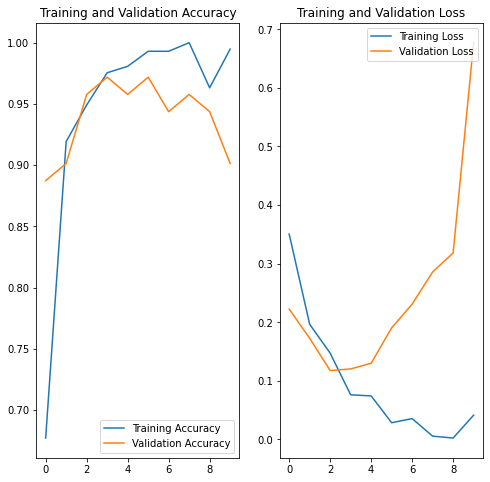

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(nb_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

high validation accuracy shows overfitting

so we add dropouts to model

What dropout technique technique does is it randomly selects neurons and ignores them during training.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), input_shape = (150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))



model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))


model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.25))

model.add(Dense(2))
model.add(Activation('softmax'))


In [ ]:
model.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

# Fit the model
history = model.fit(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps, validation_data=(val_data,val_labels))

Epoch 1/10
114/114 [==============================] - 26s 220ms/step - loss: 0.3835 - accuracy: 0.6649 - val_loss: 0.3144 - val_accuracy: 0.8451
Epoch 2/10
114/114 [==============================] - 25s 216ms/step - loss: 0.2158 - accuracy: 0.8509 - val_loss: 0.2523 - val_accuracy: 0.9014
Epoch 3/10
114/114 [==============================] - 25s 216ms/step - loss: 0.1657 - accuracy: 0.8842 - val_loss: 0.1928 - val_accuracy: 0.9296
Epoch 4/10
114/114 [==============================] - 26s 228ms/step - loss: 0.1942 - accuracy: 0.9018 - val_loss: 0.1624 - val_accuracy: 0.9296
Epoch 5/10
114/114 [==============================] - 26s 227ms/step - loss: 0.1337 - accuracy: 0.9018 - val_loss: 0.1941 - val_accuracy: 0.9155
Epoch 6/10
114/114 [==============================] - 25s 216ms/step - loss: 0.0909 - accuracy: 0.9421 - val_loss: 0.1146 - val_accuracy: 0.9577
Epoch 7/10
114/114 [==============================] - 25s 219ms/step - loss: 0.1115 - accuracy: 0.9491 - val_loss: 0.0820 - val_ac

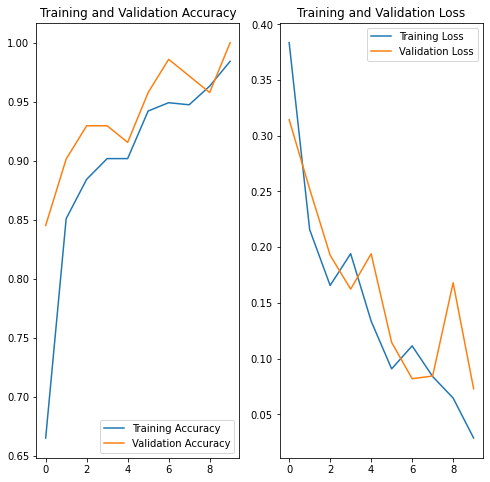

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(nb_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
test_data, test_labels = prepare_dataset(test_ds)
print(test_data.shape)

(72, 150, 150, 3)


In [ ]:
loss, acc = model.evaluate(test_data, test_labels,batch_size=5)
print('Loss and accuracy',loss,'&',acc)

15/15 [==============================] - 1s 44ms/step - loss: 0.0644 - accuracy: 0.9861
Loss and accuracy 0.0643523558974266 & 0.9861111044883728


In [ ]:
# Get predictions
pred = model.predict(test_data, batch_size=5)
pred = np.argmax(pred, axis=-1)

# original labels
labels = np.argmax(test_labels, axis=-1)
from sklearn.metrics import classification_report
print(classification_report(labels, pred))

15/15 [==============================] - 1s 45ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        35
           1       1.00      0.97      0.99        37

    accuracy                           0.99        72
   macro avg       0.99      0.99      0.99        72
weighted avg       0.99      0.99      0.99        72



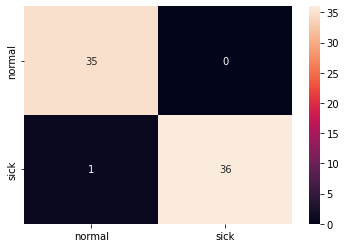

In [ ]:
import seaborn as sns

# Get the confusion matrix
cm = confusion_matrix(labels, pred)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=['normal', 'sick'],yticklabels=['normal', 'sick'] )

Labeling Unknown images

Loading unknown images 

In [ ]:
def load_unknown_images():
    images_dir = Path('/content/drive/MyDrive/Deep learning pnuemonia /deep_learning_project/deep_learning_project/dataset1/unknown_images')
    images = images_dir.glob('*.png')
    img_data = []
    for img in images:
        img_data.append(img)
    df = pd.DataFrame(img_data)
    df.columns = ['images']
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [ ]:
df_unknown_images = load_unknown_images()

df_unknown_images.shape

(50, 1)

In [ ]:
def prepare_dataset_unknown(images):
  
    data = []
    def prepare(case):
        for img in case['images']:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(150,150))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            data.append(img)
        return data
    
    d = prepare(images)
    #print(l)
    d = np.array(d)
    return d

In [ ]:
unknown_data = prepare_dataset_unknown(df_unknown_images)

In [ ]:
unknown_data.shape

(50, 150, 150, 3)

In [ ]:
# Get predictions
pred = model.predict(unknown_data, batch_size=5)
#print(pred)
pred = np.argmax(pred, axis=-1)
print(pred)

10/10 [==============================] - 0s 47ms/step
[0 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1
 0 0 1 1 0 1 0 1 1 1 0 0 0]


In [ ]:
df_unknown_images["predictions (0-Normal, 1-Sick)"] = pred
submission = df_unknown_images[["images","predictions (0-Normal, 1-Sick)"]]
submission.to_csv("predictions_3.csv", index=False)

Measuring the performance of the model using dataset2

In [ ]:
# Loading dataset 2 into a dataframe

def load_dataset2_images():
    images_dir = Path('/content/drive/MyDrive/Deep learning pnuemonia /deep_learning_project/deep_learning_project/dataset2/images')
    images = images_dir.glob('*.png')
    img_data = []
    for img in images:
        img_data.append(img)
    df = pd.DataFrame(img_data)
    df.columns = ['images']
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [ ]:
dataset2 = load_dataset2_images()
print(dataset2)

                                                images
0    /content/drive/MyDrive/Deep learning pnuemonia...
1    /content/drive/MyDrive/Deep learning pnuemonia...
2    /content/drive/MyDrive/Deep learning pnuemonia...
3    /content/drive/MyDrive/Deep learning pnuemonia...
4    /content/drive/MyDrive/Deep learning pnuemonia...
..                                                 ...
219  /content/drive/MyDrive/Deep learning pnuemonia...
220  /content/drive/MyDrive/Deep learning pnuemonia...
221  /content/drive/MyDrive/Deep learning pnuemonia...
222  /content/drive/MyDrive/Deep learning pnuemonia...
223  /content/drive/MyDrive/Deep learning pnuemonia...

[224 rows x 1 columns]


In [ ]:
# Reading the csv containing the image classes

dataset2_classes = pd.read_csv('/content/drive/MyDrive/Deep learning pnuemonia /deep_learning_project/deep_learning_project/dataset2/image_classes.csv')
print(dataset2_classes.columns)

Index(['patient ', 'diagnosis (0-Normal, 1-Sick)'], dtype='object')


In [ ]:
from pathlib import Path
dataset2['patient'] = dataset2['images'].apply(lambda path: Path(path).stem)
print(dataset2.columns)

Index(['images', 'patient'], dtype='object')


In [ ]:
# merging the image classes to the image path

dataset2_merged = pd.merge(dataset2_classes, dataset2, how='left', left_on='patient', right_on='patient')

print(dataset2_merged.columns)

dataset2_merged['diagnosis'] = dataset2_merged['diagnosis (0-Normal, 1-Sick)']

print(dataset2_merged)

In [ ]:
def prepare_dataset2(images):
 
    normal_cases = images.loc[images['diagnosis'] == 0]
    
    sick_cases = images.loc[images['diagnosis'] == 1]

    print(sick_cases)
    data, labels = ([] for x in range(2))
    def prepare(case):
        for img in case['images']:
            img = cv2.imread(str(img))
            img = cv2.resize(img,(150,150))
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32)/255.
            if 0 in case['diagnosis'].values:
                #print(case['labels'])
                label = to_categorical(0 , num_classes=2)
            else:
                #print(case['diagnosis'])
                label = to_categorical(1 , num_classes=2)
            data.append(img)
            labels.append(label)
        return data, labels
    prepare(normal_cases)
    d,l = prepare(sick_cases)
    #print(l)
    d = np.array(d)
    l = np.array(l)
    return d,l

In [ ]:
d2_data, d2_labels = prepare_dataset2(dataset2_merged)
dataset2_merged.shape
d2_data.shape

NameError: ignored